In [2]:
import numpy as np
import matplotlib.pyplot as plt
import fitle as fl
import mplhep
import uproot
import vector
mplhep.style.use(mplhep.style.LHCb2)

In [25]:
def plot_mass_spectrum(Dp_M, model_func, components, log=False):
    fig, ax = plt.subplots()
    x = np.linspace(1840, 2040, 5000)

    if log:
        plt.yscale('log')

    # histogram
    counts, edges = np.histogram(Dp_M, bins=200)
    plt.plot((edges[:-1] + edges[1:])/2, counts, label="Data")

    # main model
    plt.plot(x, model_func(x), label='Fit')

    # components
    for label, val in components.items():
        if isinstance(val, tuple):
            func, style = val
        else:
            func, style = val, {}
        plt.plot(x, func(x), label=label, **style)

    plt.ylabel('Entries per 1 MeV')
    plt.xlabel('$m(K K \pi)$         [MeV]')

    ymax = np.max(model_func(x)) * (2.5 if log else 1.05)
    plt.axis([1840, 2040, 40, ymax])

    plt.legend(bbox_to_anchor=[0.58, 0.5] if log else [0.69, 1])
    plt.text(
        0.05, 0.95, 'LHCb Preliminary',
        ha='left', va='top',
        transform=ax.transAxes,
        size=40
    )

    return fig, ax

In [38]:
Dp_M = np.load("../data/observed/kpp.npy")
Dp_M = Dp_M[Dp_M < 1970]

In [32]:
Dp_data = np.load("../data/mc/histograms/Dp.npy")

Dp_x = Dp_data[:, 0]
Dp_c = Dp_data[:, 1]

Dp_mother_mass = 1869.65

In [33]:
def convolve(i, d_x, c, mass_mother, mu, sigma):
    w = fl.indecise(fl.const(c), i)
    centers = fl.indecise(fl.const(d_x), i)
    shifted_x = fl.INPUT + mass_mother - mu
    g = fl.gaussian(centers, sigma) % shifted_x
    weighted = w * g
    ret = fl.Reduction(weighted, i)
    j = fl.index(2)
    iX = fl.indecise(fl.INPUT, j)
    return ret / ((iX[{j:1}]-iX[{j:0}]) * fl.mnp.sum(ret))

In [39]:
i = fl.index(len(Dp_c))
conv_kkp_mass = fl.Param(1860)('mass')
conv_kkp_signal = (fl.Param.positive(500000)* convolve(i,Dp_x,Dp_c,Dp_mother_mass, conv_kkp_mass, fl.Param.positive(5))+
                   fl.Param.positive(500000)* convolve(i, Dp_x,Dp_c,Dp_mother_mass, conv_kkp_mass, fl.Param.positive(10)))
conv_kkp_tail = fl.Param.positive(40000) * fl.exponential(tau=fl.Param.positive(100)) % (fl.INPUT-1790)
conv_kkp = conv_kkp_signal+conv_kkp_tail

In [40]:
fit_conv_kkp = fl.fit(conv_kkp | fl.Cost.chi2(Dp_M, 200))
fit_conv_kkp.minimizer

Compiling model sum(((const_140686765604272()) - (5e+05 * ((add_reduce((indecise(const_140686770867248(), range(0, 1200))) * (1 / (5 * 2.5066282746310002) * (exp(-0.5 * (((const_140686765601392()) + 1869.65 - mass=1860 - (indecise(const_140686890723632(), range(0, 1200)))) / 5) ** 2))), index=range(0, 1200))) / (((indecise(const_140686765601392(), 1)) - (indecise(const_140686765601392(), 0))) * (sum(add_reduce((indecise(const_140686770867248(), range(0, 1200))) * (1 / (5 * 2.5066282746310002) * (exp(-0.5 * (((const_140686765601392()) + 1869.65 - mass=1860 - (indecise(const_140686890723632(), range(0, 1200)))) / 5) ** 2))), index=range(0, 1200)))))) + 5e+05 * ((add_reduce((indecise(const_140686770867248(), range(0, 1200))) * (1 / (10 * 2.5066282746310002) * (exp(-0.5 * (((const_140686765601392()) + 1869.65 - mass=1860 - (indecise(const_140686890723632(), range(0, 1200)))) / 10) ** 2))), index=range(0, 1200))) / (((indecise(const_140686765601392(), 1)) - (indecise(const_140686765601392()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7568                       │        Nfcn = 173, Ngrad = 27        │
│ EDM = 3.93e-05 (Goal: 0.0002)    │            time = 7.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  6.925e6  │  0.032e6  │            │            │  1e-06  │         │       │
│ 1 │ x1   │   6.781   │   0.010   │            │            │  1e-06  │         │       │
│ 2 │ x2   │1.8692941e3│0.0000025e3│            │            │         │         │       │
│ 3 │ x3   │  2.117e6  │  0.032e6  │            │            │  1e-06  │         │       │
│ 4 │ x4   │  10.729   │   0.034   │            │            │  1e-06  │         │       │
│ 5 │ x5   │  147.5e3  │   0.8e3   │            │            │  1e-06  │         │       │
│ 6 │ x6   │   121.8   │    0.9    │            │            │  1e-06  │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────────────────────────────────────────────────────────────────────┐
│    │           x0           x1           x2           x3           x4           x5           x6 │
├────┼────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │     1.03e+09    291.29721  -165.846e-3         -1e9  1.0423086e3       -5.3e6    -1.7358e3 │
│ x1 │    291.29721     9.06e-05        -0e-6   -290.45980      0.28e-3     -1.32483     -0.46e-3 │
│ x2 │  -165.846e-3        -0e-6     6.33e-06   125.937e-3        -2e-6     7.027e-3       -65e-6 │
│ x3 │         -1e9   -290.45980   125.937e-3     1.02e+09 -1.0379824e3        5.2e6     1.7944e3 │
│ x4 │  1.0423086e3      0.28e-3        -2e-6 -1.0379824e3      0.00113      -6.6804      -0.0021 │
│ x5 │       -5.3e6     -1.32483     7.027e-3        5.2e6      -6.6804     5.93e+05        386.8 │
│ x6 │    -1.7358e3     -0.46e-3       -65e-6     1.7944e3      -0.0021        386.8        0.861 │
└────┴────────────────────────────────────────────────────────────────────────────────────────────┘

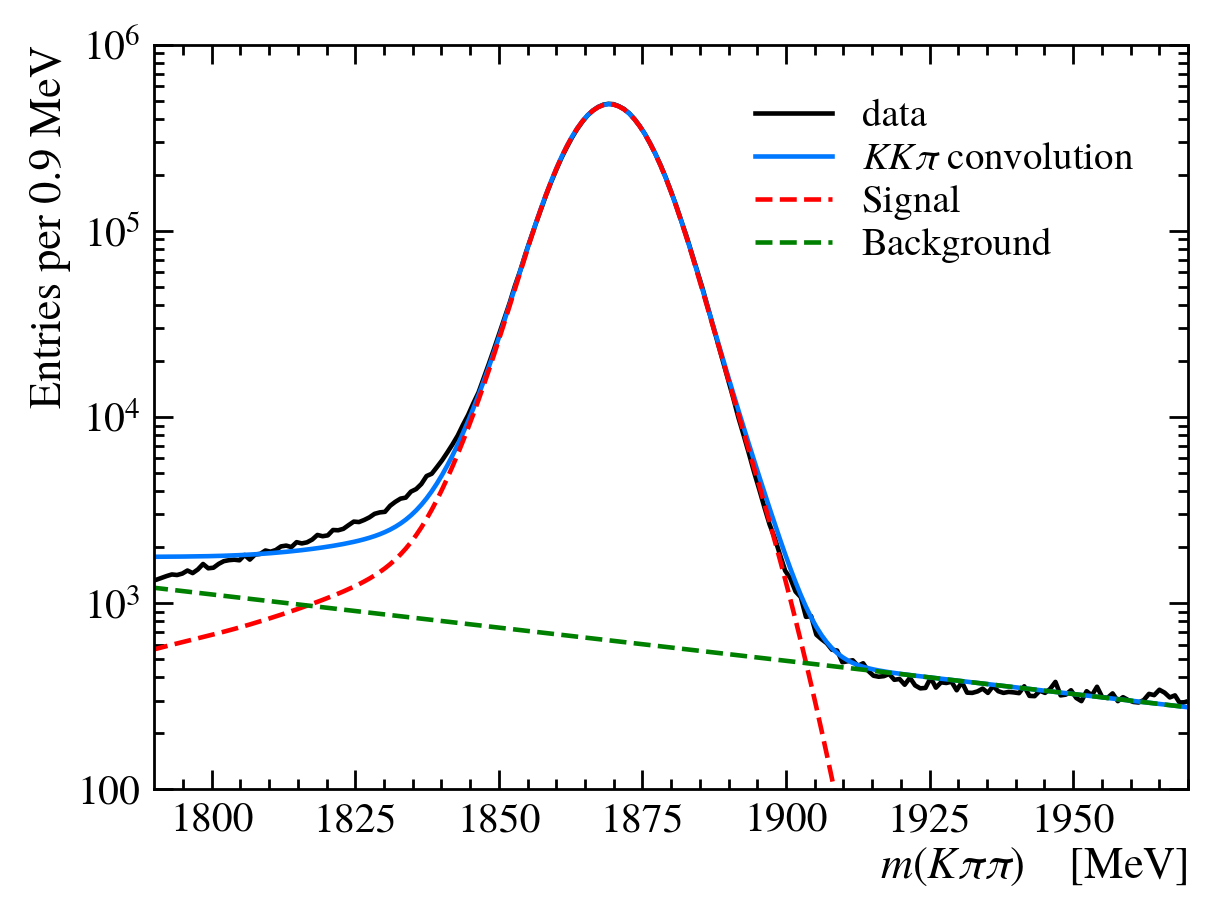

In [45]:
counts, centers = np.histogram(Dp_M, 200)
x = (centers[1:] + centers[:-1])/2
plt.plot(x, counts, color='black', label='data')
plt.plot(x,conv_kkp(x), label='$KK\pi$ convolution')
plt.plot(x,conv_kkp_signal(x), linestyle='--',color='red', label='Signal')
plt.plot(x,conv_kkp_tail(x), linestyle='--',color='green', label='Background')
plt.yscale('log')
plt.axis([1790,1970, 100,10**6])
plt.xlabel('$m(K \pi \pi)$    [MeV]')
plt.ylabel('Entries per 0.9 MeV')
plt.legend()
plt.show()

In [46]:
kpp_data = np.load("../data/mc/histograms/kpp.npy")

kpp_x = kpp_data[:, 0]
kpp_c = kpp_data[:, 1]

Dp_mother_mass = 1869.65

In [57]:
i = fl.index(len(kpp_c))
conv1_mass = fl.Param(1860)('mass')
conv1_signal = (fl.Param.positive(500000)* convolve(i,kpp_x,kpp_c,Dp_mother_mass, conv1_mass, fl.Param.positive(5))+
                   fl.Param.positive(500000)* convolve(i, kpp_x,kpp_c,Dp_mother_mass, conv1_mass, fl.Param.positive(10)))
conv1_tail = fl.Param.positive(40000) * fl.exponential(tau=fl.Param.positive(100)) % (fl.INPUT-1790)
conv1 = conv1_signal+conv1_tail

In [58]:
fit_conv1 = fl.fit(conv1 | fl.Cost.chi2(Dp_M, 200))
fit_conv1.minimizer

Compiling model sum(((const_140685709261296()) - (5e+05 * ((add_reduce((indecise(const_140686743982608(), range(0, 1200))) * (1 / (5 * 2.5066282746310002) * (exp(-0.5 * (((const_140685709558576()) + 1869.65 - mass=1860 - (indecise(const_140686761332432(), range(0, 1200)))) / 5) ** 2))), index=range(0, 1200))) / (((indecise(const_140685709558576(), 1)) - (indecise(const_140685709558576(), 0))) * (sum(add_reduce((indecise(const_140686743982608(), range(0, 1200))) * (1 / (5 * 2.5066282746310002) * (exp(-0.5 * (((const_140685709558576()) + 1869.65 - mass=1860 - (indecise(const_140686761332432(), range(0, 1200)))) / 5) ** 2))), index=range(0, 1200)))))) + 5e+05 * ((add_reduce((indecise(const_140686743982608(), range(0, 1200))) * (1 / (10 * 2.5066282746310002) * (exp(-0.5 * (((const_140685709558576()) + 1869.65 - mass=1860 - (indecise(const_140686761332432(), range(0, 1200)))) / 10) ** 2))), index=range(0, 1200))) / (((indecise(const_140685709558576(), 1)) - (indecise(const_140685709558576()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1144                       │        Nfcn = 162, Ngrad = 25        │
│ EDM = 5.86e-06 (Goal: 0.0002)    │           time = 10.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  6.99e6   │  0.04e6   │            │            │  1e-06  │         │       │
│ 1 │ x1   │   6.771   │   0.010   │            │            │  1e-06  │         │       │
│ 2 │ x2   │1.8693942e3│0.0000025e3│            │            │         │         │       │
│ 3 │ x3   │  2.11e6   │  0.04e6   │            │            │  1e-06  │         │       │
│ 4 │ x4   │   10.55   │   0.04    │            │            │  1e-06  │         │       │
│ 5 │ x5   │  0.268e6  │  0.014e6  │            │            │  1e-06  │         │       │
│ 6 │ x6   │    600    │    40     │            │            │  1e-06  │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────────────────────────────────────────────────────────────────────┐
│    │           x0           x1           x2           x3           x4           x5           x6 │
├────┼────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │     1.35e+09    361.41456  -635.620e-3       -1.3e9  1.3109707e3       0.04e9      154.0e3 │
│ x1 │    361.41456     0.000106        -0e-6   -360.34805      0.34e-3      9.30405     34.73e-3 │
│ x2 │  -635.620e-3        -0e-6     6.34e-06   592.132e-3        -2e-6    -1.303916    -3.789e-3 │
│ x3 │       -1.3e9   -360.34805   592.132e-3     1.33e+09 -1.3055073e3      -0.04e9     -140.7e3 │
│ x4 │  1.3109707e3      0.34e-3        -2e-6 -1.3055073e3      0.00136      51.6286       0.1882 │
│ x5 │       0.04e9      9.30405    -1.303916      -0.04e9      51.6286     1.93e+08      540.8e3 │
│ x6 │      154.0e3     34.73e-3    -3.789e-3     -140.7e3       0.1882      540.8e3     1.54e+03 │
└────┴────────────────────────────────────────────────────────────────────────────────────────────┘

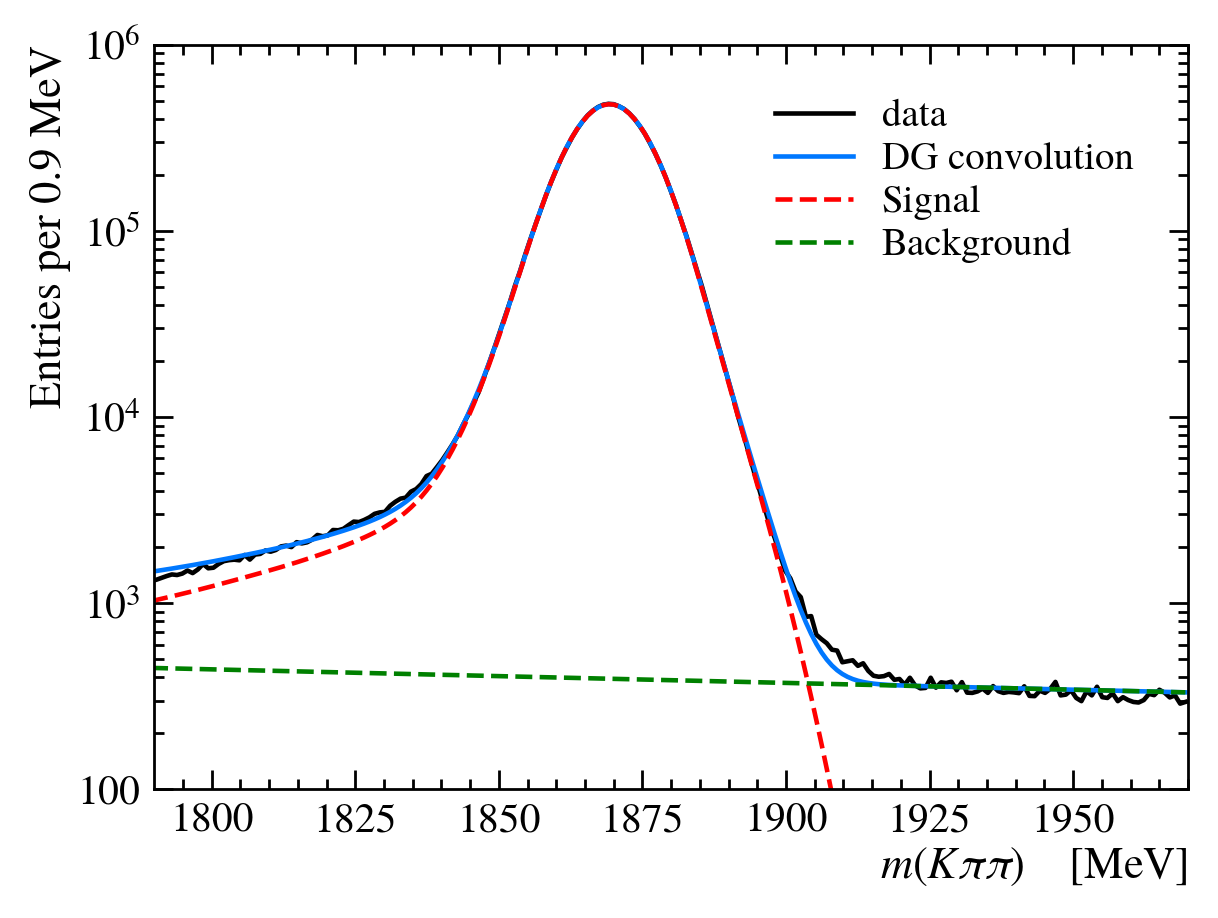

In [59]:
plt.plot(x, counts, color='black', label='data')
plt.plot(x,conv1(x), label='DG convolution')
plt.plot(x,conv1_signal(x), linestyle='--',color='red', label='Signal')
plt.plot(x, conv1_tail(x), linestyle='--',color='green', label='Background')
#plt.plot(tanh1.x,tanh1.gen_y(tanh1.x), color='red', label='$K\pi\pi$ convolution')
plt.yscale('log')
plt.axis([1790,1970, 100,10**6])
plt.xlabel('$m(K \pi \pi)$    [MeV]')
plt.ylabel('Entries per 0.9 MeV')
plt.legend()
plt.show()

In [60]:
conv2_mass = fl.Param(1860)('mass')
conv2_signal = (fl.Param.positive(500000)* convolve(i,kpp_x,kpp_c,Dp_mother_mass, conv2_mass, fl.Param.positive(5))+
                   fl.Param.positive(500000)* convolve(i, kpp_x,kpp_c,Dp_mother_mass, conv2_mass, fl.Param.positive(6)) + 
                   fl.Param.positive(500000)* convolve(i, kpp_x,kpp_c,Dp_mother_mass, conv2_mass, fl.Param.positive(10)))
conv2_tail = fl.Param.positive(40000) * fl.exponential(tau=fl.Param.positive(100)) % (fl.INPUT-1790)
conv2 = conv2_signal+conv2_tail

In [61]:
fit_conv2 = fl.fit(conv2 | fl.Cost.chi2(Dp_M, 200))
fit_conv2.minimizer

Compiling model sum(((const_140685706389040()) - (5e+05 * ((add_reduce((indecise(const_140686743982608(), range(0, 1200))) * (1 / (5 * 2.5066282746310002) * (exp(-0.5 * (((const_140685713912432()) + 1869.65 - mass=1860 - (indecise(const_140686761332432(), range(0, 1200)))) / 5) ** 2))), index=range(0, 1200))) / (((indecise(const_140685713912432(), 1)) - (indecise(const_140685713912432(), 0))) * (sum(add_reduce((indecise(const_140686743982608(), range(0, 1200))) * (1 / (5 * 2.5066282746310002) * (exp(-0.5 * (((const_140685713912432()) + 1869.65 - mass=1860 - (indecise(const_140686761332432(), range(0, 1200)))) / 5) ** 2))), index=range(0, 1200)))))) + 5e+05 * ((add_reduce((indecise(const_140686743982608(), range(0, 1200))) * (1 / (6 * 2.5066282746310002) * (exp(-0.5 * (((const_140685713912432()) + 1869.65 - mass=1860 - (indecise(const_140686761332432(), range(0, 1200)))) / 6) ** 2))), index=range(0, 1200))) / (((indecise(const_140685713912432(), 1)) - (indecise(const_140685713912432(), 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 374.8                      │        Nfcn = 317, Ngrad = 70        │
│ EDM = 3.13e-05 (Goal: 0.0002)    │           time = 16.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  3.63e6   │  0.14e6   │            │            │  1e-06  │         │       │
│ 1 │ x1   │   9.13    │   0.10    │            │            │  1e-06  │         │       │
│ 2 │ x2   │1.8693939e3│0.0000025e3│            │            │         │         │       │
│ 3 │ x3   │  5.33e6   │  0.16e6   │            │            │  1e-06  │         │       │
│ 4 │ x4   │   6.424   │   0.034   │            │            │  1e-06  │         │       │
│ 5 │ x5   │  0.139e6  │  0.021e6  │            │            │  1e-06  │         │       │
│ 6 │ x6   │   17.2    │    0.6    │            │            │  1e-06  │         │       │
│ 7 │ x7   │  0.343e6  │  0.035e6  │            │            │  1e-06  │         │       │
│ 8 │ x8   │  0.88e3   │  0.11e3   │            │            │  1e-06  │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │           x0           x1           x2           x3           x4           x5           x6           x7           x8 │
├────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │     2.11e+10 -13.759511e3     3.043744    -0.024e12 -4.8965283e3        2.5e9   -69.5079e3       -0.5e9     -2.050e6 │
│ x1 │ -13.759511e3      0.00954        -2e-6  15.678090e3       0.0031  -1.891637e3        0.054      447.277        1.690 │
│ x2 │     3.043744        -2e-6     6.34e-06    -3.354015        -1e-6   252.958e-3       -12e-6    -3.622845   -11.186e-3 │
│ x3 │    -0.024e12  15.678090e3    -3.354015     2.66e+10  5.4714448e3       -2.9e9    82.5405e3        0.7e9      2.515e6 │
│ x4 │ -4.8965283e3       0.0031        -1e-6  5.4714448e3      0.00115    -567.3367       0.0159     125.7249       0.4753 │
│ x5 │        2.5e9  -1.891637e3   252.958e-3       -2.9e9    -567.3367     4.29e+08   -12.7894e3       -0.1e9     -0.413e6 │
│ x6 │   -69.5079e3        0.054       -12e-6    82.5405e3       0.0159   -12.7894e3        0.396     4.1520e3         15.6 │
│ x7 │       -0.5e9      447.277    -3.622845        0.7e9     125.7249       -0.1e9     4.1520e3      1.2e+09      3.652e6 │
│ x8 │     -2.050e6        1.690   -11.186e-3      2.515e6       0.4753     -0.413e6         15.6      3.652e6     1.12e+04 │
└────┴──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

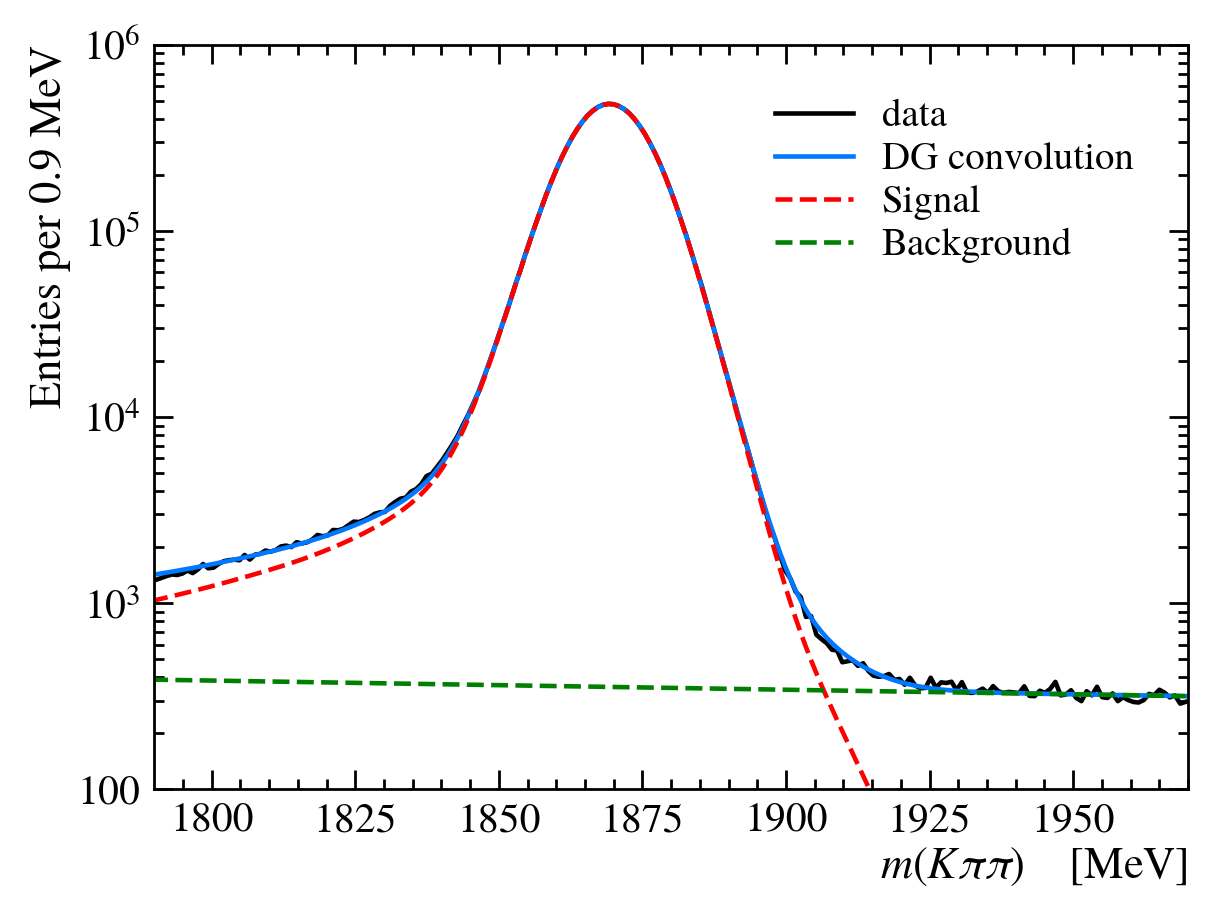

In [62]:
plt.plot(x, counts, color='black', label='data')
plt.plot(x,conv2(x), label='DG convolution')
plt.plot(x,conv2_signal(x), linestyle='--',color='red', label='Signal')
plt.plot(x, conv2_tail(x), linestyle='--',color='green', label='Background')
plt.yscale('log')
plt.axis([1790,1970, 100,10**6])
plt.xlabel('$m(K \pi \pi)$    [MeV]')
plt.ylabel('Entries per 0.9 MeV')
plt.legend()
plt.show()

In [63]:
from scipy.special import erf

def crystalball(alpha, n, xbar, sigma):
    x = fl.INPUT
    n_over_alpha = n/alpha
    exp = fl.mnp.exp(-0.5*alpha ** 2)
    A = (n_over_alpha)**n*exp
    B =  n_over_alpha - alpha
    C = n_over_alpha/(n-1)*exp
    D = np.sqrt(0.5*np.pi)*(1 + fl.Model(lambda a: erf(a), [alpha/np.sqrt(2)]))
    N = 1/(sigma*(C + D))

    mask = (x - xbar)/sigma > -alpha

    return fl.mnp.where((x - xbar)/sigma > -alpha, 
              N*fl.mnp.exp(-0.5*((x-xbar)/sigma)**2),
              N*A*(B - (x-xbar)/sigma)**-n
             )


In [69]:
from scipy.stats import norm

def gaussian(mu, sigma):
    return fl.Model(lambda x, mu, sigma: norm.pdf(x, loc=mu, scale=sigma), [fl.INPUT, mu,sigma])

In [82]:
crys1_mass = fl.Param(1870)('mass')
crys1_signal = (fl.Param.positive(600000)* crystalball(fl.Param(0,10)(5), fl.Param(3)(1,30), crys1_mass, fl.Param.positive(5)('s1')) + 
            fl.Param.positive(600000)* gaussian(crys1_mass, fl.Param.positive(6)('s2')))
crys1_tail = fl.Param.positive(40000) * fl.exponential(tau=fl.Param.positive(100)) % (fl.INPUT-1790)
crys1 = crys1_signal+crys1_tail

In [83]:
fit_crys1 = fl.fit(crys1 | fl.Cost.chi2(Dp_M, 200), numba=False, grad=False)
fit_crys1.minimizer

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2537                       │             Nfcn = 2991              │
│ EDM = 9.73e-05 (Goal: 0.0002)    │            time = 1.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   8.6e6   │   0.7e6   │            │            │  1e-06  │         │       │
│ 1 │ x1   │1.8692303e3│0.0000026e3│            │            │         │         │       │
│ 2 │ x2   │   6.692   │   0.010   │            │            │  1e-06  │         │       │
│ 3 │ x3   │   2.360   │   0.005   │            │            │    0    │   10    │       │
│ 4 │ x4   │   1.026   │   0.007   │            │            │    1    │   30    │       │
│ 5 │ x5   │  2.80e6   │  0.04e6   │            │            │  1e-06  │         │       │
│ 6 │ x6   │   9.879   │   0.027   │            │            │  1e-06  │         │       │
│ 7 │ x7   │   171e3   │    4e3    │            │            │  1e-06  │         │       │
│ 8 │ x8   │    277    │    12     │            │            │  1e-06  │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │            x0            x1            x2            x3            x4            x5            x6            x7            x8 │
├────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │      4.71e+11   -217.419256    -246.87091 1.912830437e3 -4.93892269e3         0.2e9   1.6739886e3       1.207e9     4.39572e6 │
│ x1 │   -217.419256      6.93e-06         -4e-6         -3e-6          2e-6     16.862483        -14e-6    449.166e-3      1.476e-3 │
│ x2 │    -246.87091         -4e-6      0.000111      0.026e-3       0.01e-3    -390.02342       0.24e-3      -2.99155      -6.43e-3 │
│ x3 │ 1.912830437e3         -3e-6      0.026e-3       2.1e-05     -0.019e-3   -108.458975      0.085e-3   -634.653e-3     -0.609e-3 │
│ x4 │ -4.93892269e3          2e-6       0.01e-3     -0.019e-3      5.19e-05     -16.05585      -0.01e-3     -12.45504     -45.18e-3 │
│ x5 │         0.2e9     16.862483    -390.02342   -108.458975     -16.05585      1.53e+09  -1.0095693e3       0.014e9       29.32e3 │
│ x6 │   1.6739886e3        -14e-6       0.24e-3      0.085e-3      -0.01e-3  -1.0095693e3      0.000729       -9.7583      -18.7e-3 │
│ x7 │       1.207e9    449.166e-3      -2.99155   -634.653e-3     -12.45504       0.014e9       -9.7583      1.38e+07       41.66e3 │
│ x8 │     4.39572e6      1.476e-3      -6.43e-3     -0.609e-3     -45.18e-3       29.32e3      -18.7e-3       41.66e3           136 │
└────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

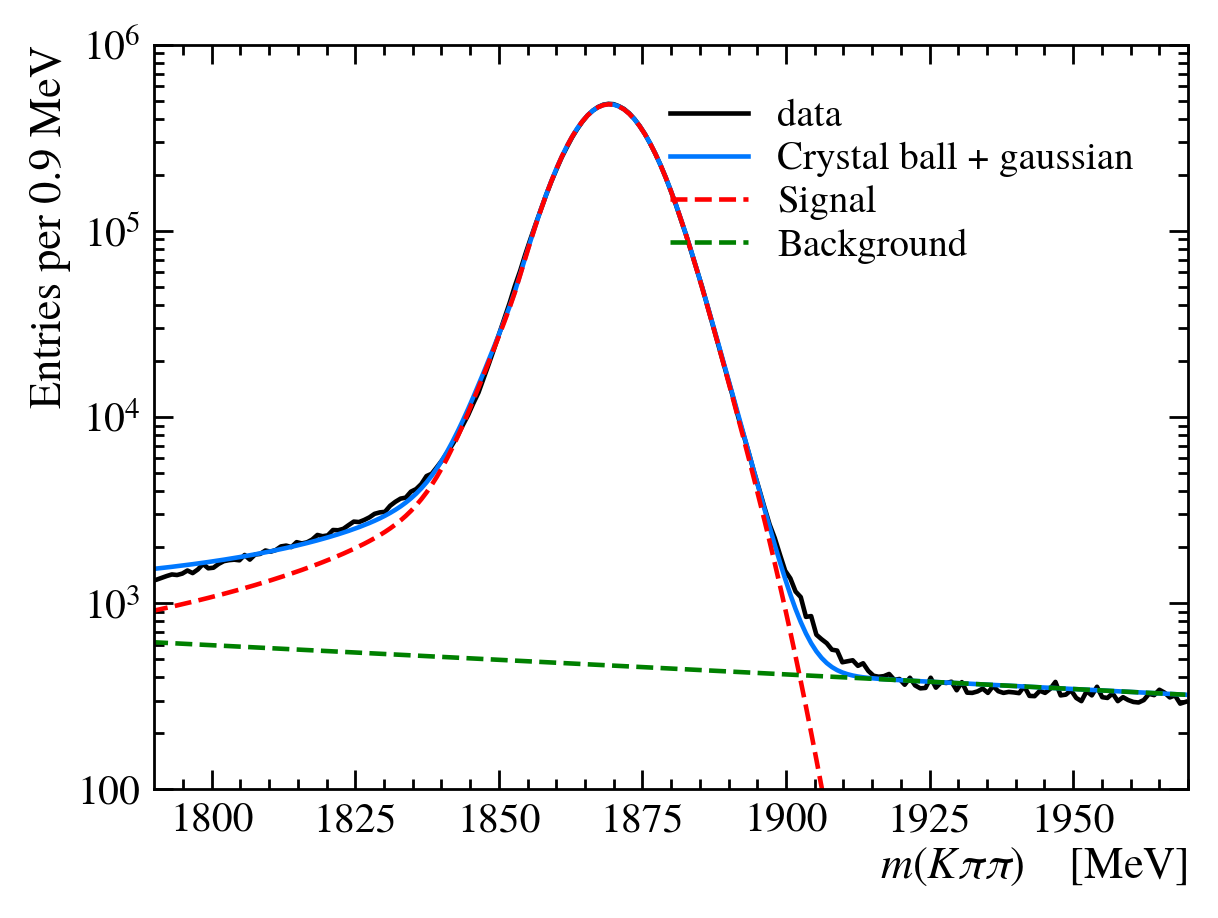

In [84]:
plt.plot(x, counts, color='black', label='data')
plt.plot(x,crys1(x), label='Crystal ball + gaussian')
plt.plot(x,crys1_signal(x), linestyle='--',color='red', label='Signal')
plt.plot(x, crys1_tail(x), linestyle='--',color='green', label='Background')
plt.yscale('log')
plt.axis([1790,1970, 100,10**6])
plt.xlabel('$m(K \pi \pi)$    [MeV]')
plt.ylabel('Entries per 0.9 MeV')
plt.legend()
plt.show()

In [85]:
crys2_mass = fl.Param(1870)('mass')
crys2_signal = (fl.Param.positive(600000)* crystalball(fl.Param(0,10)(5), fl.Param(3)(1,30), crys2_mass, fl.Param.positive(5)('s1')) + 
            fl.Param.positive(600000)* gaussian(crys2_mass, fl.Param.positive(6)('s2')) +
            fl.Param.positive(600000)* gaussian(crys2_mass, fl.Param.positive(10)('s2')))
crys2_tail = fl.Param.positive(40000) * fl.exponential(tau=fl.Param.positive(100)) % (fl.INPUT-1790)
crys2 = crys2_signal+crys2_tail

In [86]:
fit_crys2 = fl.fit(crys2 | fl.Cost.chi2(Dp_M, 200), numba=False, grad=False)
fit_crys2.minimizer

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 807.5                      │             Nfcn = 22890             │
│ EDM = 4.74e-05 (Goal: 0.0002)    │           time = 17.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  202.8e6  │   2.2e6   │            │            │  1e-06  │         │       │
│ 1 │ x1   │1.8692695e3│0.0000026e3│            │            │         │         │       │
│ 2 │ x2   │   5.978   │   0.014   │            │            │  1e-06  │         │       │
│ 3 │ x3   │   1.963   │   0.005   │            │            │    0    │   10    │       │
│ 4 │ x4   │ 1.000377  │ 0.000004  │            │            │    1    │   30    │       │
│ 5 │ x5   │  5.842e6  │  0.026e6  │            │            │  1e-06  │         │       │
│ 6 │ x6   │   7.920   │   0.015   │            │            │  1e-06  │         │       │
│ 7 │ x7   │  0.529e6  │  0.017e6  │            │            │  1e-06  │         │       │
│ 8 │ x8   │   13.29   │   0.09    │            │            │  1e-06  │         │       │
│ 9 │ x9   │  0.357e6  │  0.020e6  │            │            │  1e-06  │         │       │
│ 10│ x10  │    900    │    60     │            │            │  1e-06  │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │              x0              x1              x2              x3              x4              x5              x6              x7              x8              x9             x10 │
├─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  x0 │        4.92e+12      223.318628      -394.29940     -705.611233 -8.664750732182           0.7e9        70.62311         -0.45e9         530.928           3.0e9        9.6040e6 │
│  x1 │      223.318628         6.8e-06           -6e-6           -2e-6        0.512e-9        8.310950            0e-6       -1.797245            4e-6        2.915403        9.663e-3 │
│  x2 │      -394.29940           -6e-6        0.000186        0.032e-3       -1.881e-9      -226.17250        -0.03e-3        47.51213        -0.22e-3         7.68804        22.48e-3 │
│  x3 │     -705.611233           -2e-6        0.032e-3        2.53e-05       -2.330e-9      -97.351843        0.051e-3      -34.125831        0.148e-3       -8.947941      -27.849e-3 │
│  x4 │ -8.664750732182        0.512e-9       -1.881e-9       -2.330e-9        1.76e-11  4.958477654e-3       -1.805e-9   425.864485e-6       -4.613e-9  6.031467808e-3    19.514865e-6 │
│  x5 │           0.7e9        8.310950      -226.17250      -97.351843  4.958477654e-3        6.56e+08       -65.70349         -0.09e9         675.338              -0           0.1e3 │
│  x6 │        70.62311            0e-6        -0

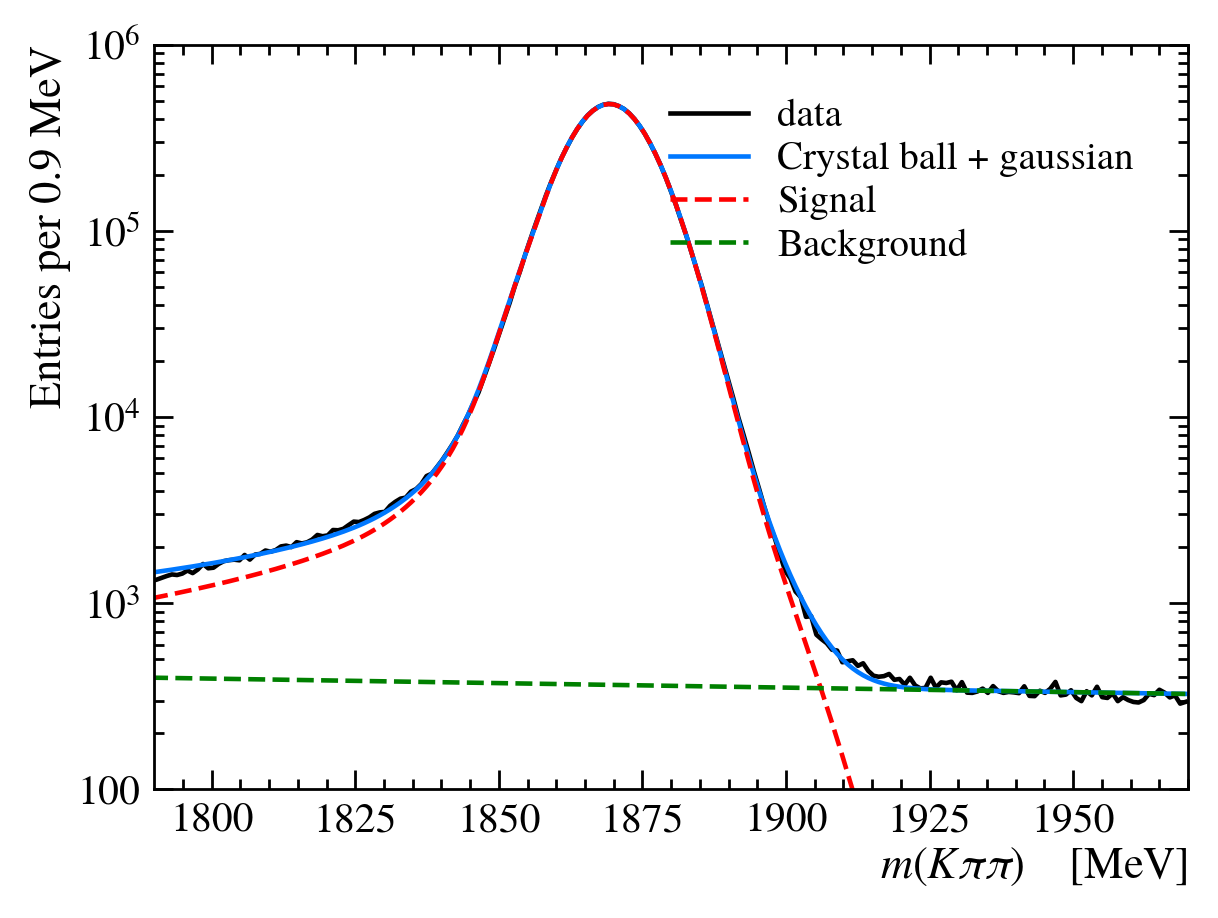

In [87]:
plt.plot(x, counts, color='black', label='data')
plt.plot(x,crys2(x), label='Crystal ball + gaussian')
plt.plot(x,crys2_signal(x), linestyle='--',color='red', label='Signal')
plt.plot(x, crys2_tail(x), linestyle='--',color='green', label='Background')
plt.yscale('log')
plt.axis([1790,1970, 100,10**6])
plt.xlabel('$m(K \pi \pi)$    [MeV]')
plt.ylabel('Entries per 0.9 MeV')
plt.legend()
plt.show()

In [88]:
fits = [fit_crys1, fit_crys2, fit_conv_kkp, fit_conv1, fit_conv2]
for fit in fits:
    print(f" & {len(fit.values)} & {fit.values['mass']:.3f} ± {fit.errors['mass']:.3f} &  & {fit.fval/(200 - len(fit.values)):.1f} \\\\")

 & 9 & 1869.230 ± 0.003 &  & 13.3 \\
 & 10 & 1869.269 ± 0.003 &  & 4.3 \\
 & 7 & 1869.294 ± 0.003 &  & 39.2 \\
 & 7 & 1869.394 ± 0.003 &  & 5.9 \\
 & 9 & 1869.394 ± 0.003 &  & 2.0 \\


In [49]:
# old results
for fit in fits:
    print(f" & {np.sum(~fit.minimizer.fixed)} & {fit.mu.value:.3f} ± {fit.mu.error:.3f} & {fit.minimizer.fval/(len(fit.x) - np.sum(~fit.minimizer.fixed)):.1f} \\\\")

 & 9 & 1869.201 ± 0.003 15.3 \\
 & 11 & 1869.271 ± 0.003 4.2 \\
 & 7 & 1869.294 ± 0.003 38.4 \\
 & 7 & 1870.394 ± 0.003 5.9 \\
 & 9 & 1870.394 ± 0.003 2.0 \\
